In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.sql.types import *

# Create a Spark session
spark = SparkSession.builder.appName("722").getOrCreate()

# Load the dataset from the uploaded path
# data = spark.read.csv("water_potability.csv", header=True, inferSchema=True)
df1 = spark.read.csv("water_potability.csv", header=True, inferSchema=True)
df2 = spark.read.csv("water_potability_2.csv", header=True, inferSchema=True)
df3 = spark.read.csv("water_potability_3.csv", header=True, inferSchema=True)

# 合并三个DataFrame
data = df1.union(df2).union(df3)
# Show the summary statistics
data.describe().show()

# Show the columns
print(data.columns)
# 获取行数和列数
num_rows = data.count()
num_cols = len(data.columns)

# 输出行数和列数
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")
data.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 10:24:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|                  ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|        Potability|
+-------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|                8355|              9828|              9828|              9828|              7485|              9828|              9828|              9342|              9828|              9828|
|   mean|   7.079785231391082|196.37464730006275|22014.093577965137| 7.120850472301293| 333.8544560831639|426.18850814731996| 14.28489174470498| 66.39629294676803|3.9664115852595114|0.39010989

In [3]:
df = data.toPandas()
df.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


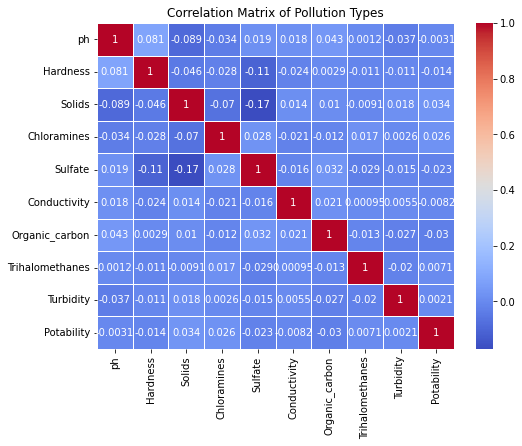

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


# Convert to Pandas for visualization
df = data.toPandas()
df.head(5)
df_corr = df.corr()


# 使用Seaborn的heatmap函数来绘制相关性矩阵。
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Pollution Types')
plt.show()

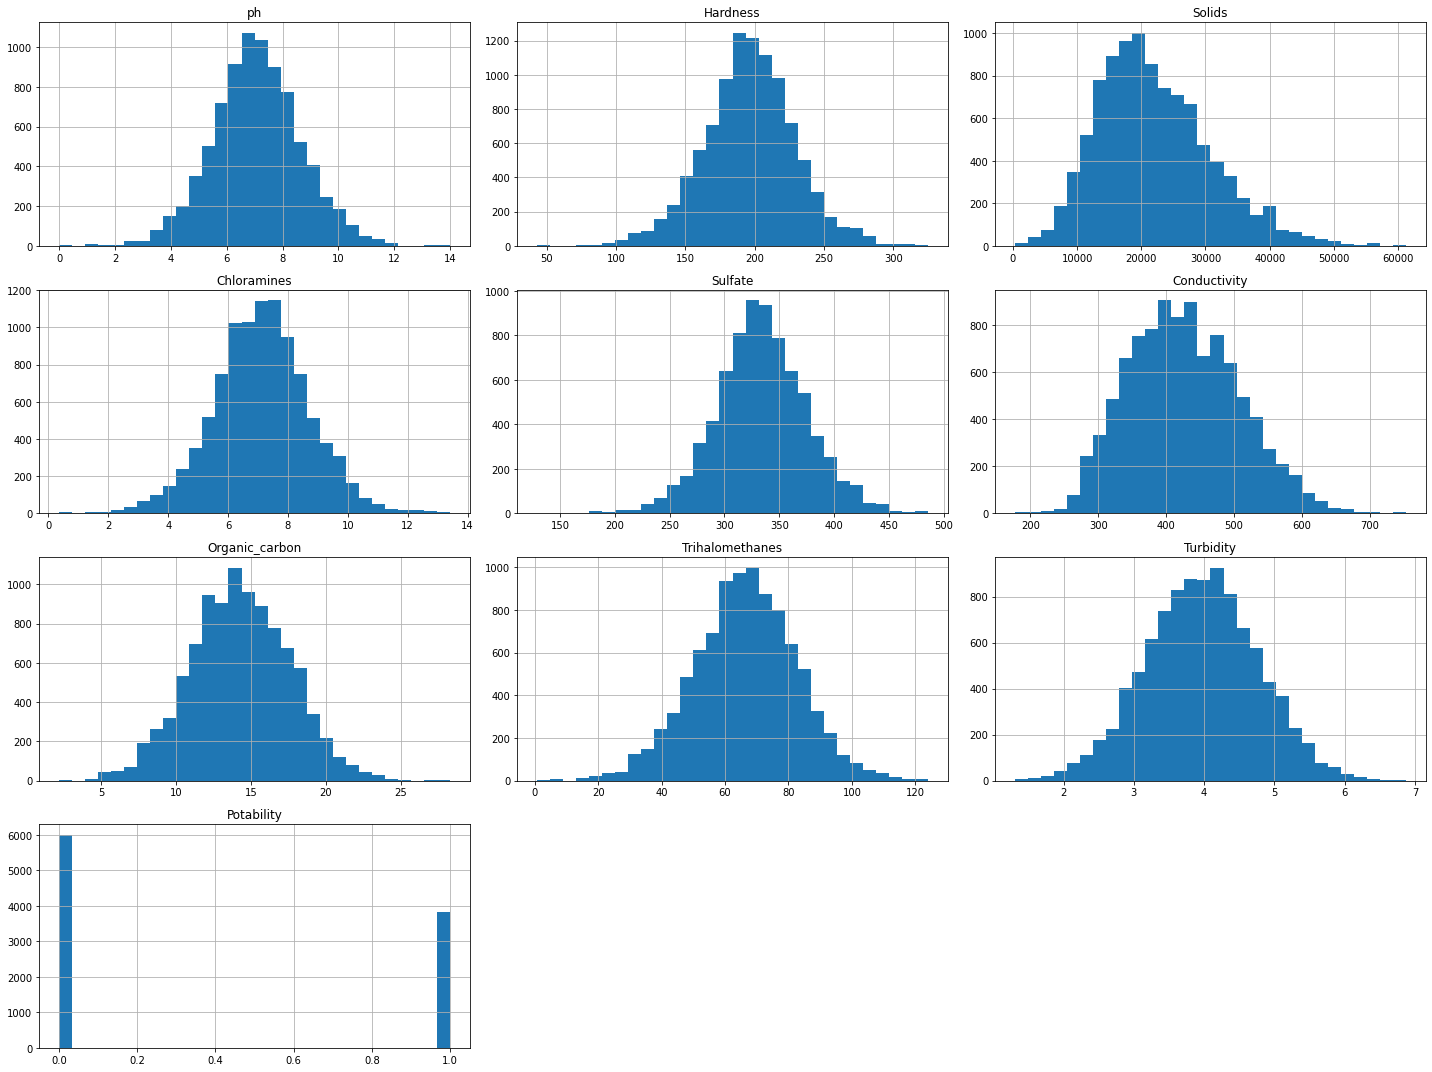

In [5]:
df.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

In [6]:
#缺失值
missing_values = data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data.columns])

# 将结果转换为 Pandas 进行进一步处理
missing_data = missing_values.toPandas().transpose()
missing_data.columns = ["missing_count"]

print("Columns with missing values:")
print(missing_data)


Columns with missing values:
                 missing_count
ph                        1473
Hardness                     0
Solids                       0
Chloramines                  0
Sulfate                   2343
Conductivity                 0
Organic_carbon               0
Trihalomethanes            486
Turbidity                    0
Potability                   0


In [7]:
# 离群值
def calculate_outliers(df, column):
    q1 = df.approxQuantile(column, [0.25], 0.05)[0]
    q3 = df.approxQuantile(column, [0.75], 0.05)[0]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound)).count()

# 计算每列的离群值数量
outliers = {column: calculate_outliers(data, column) for column in data.columns if data.select(column).dtypes[0][1] in ['int', 'double']}

# 输出每列的离群值数量
print("Columns with outliers and their counts:")
for column, count in outliers.items():
    print(f"{column}: {count}")

Columns with outliers and their counts:
ph: 223
Hardness: 406
Solids: 213
Chloramines: 314
Sulfate: 242
Conductivity: 74
Organic_carbon: 167
Trihalomethanes: 207
Turbidity: 131
Potability: 0


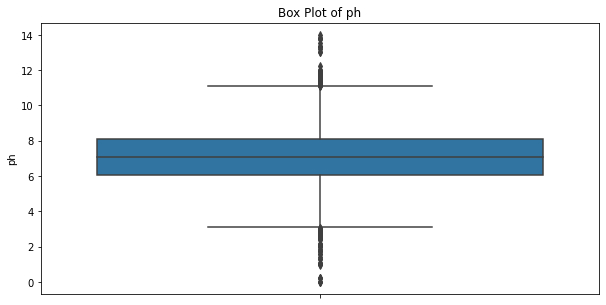

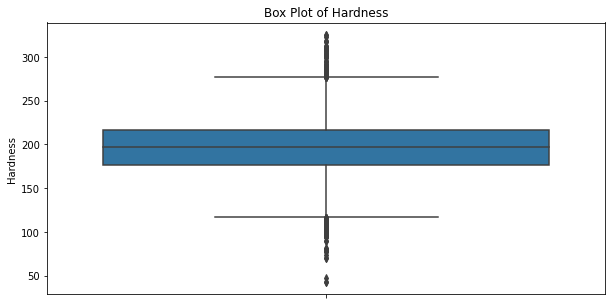

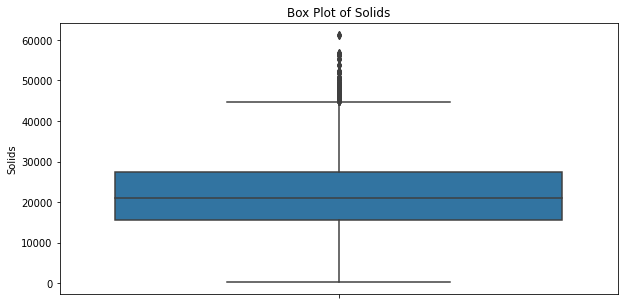

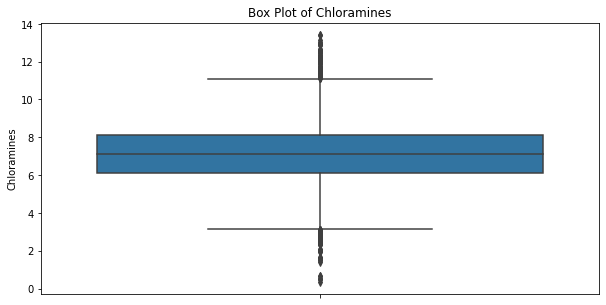

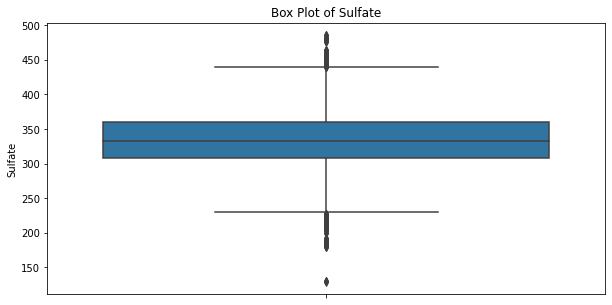

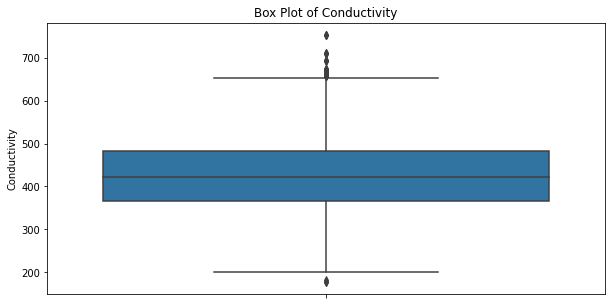

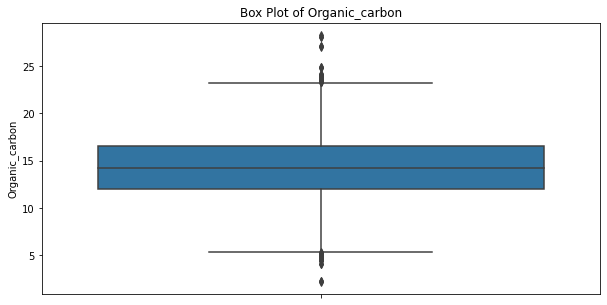

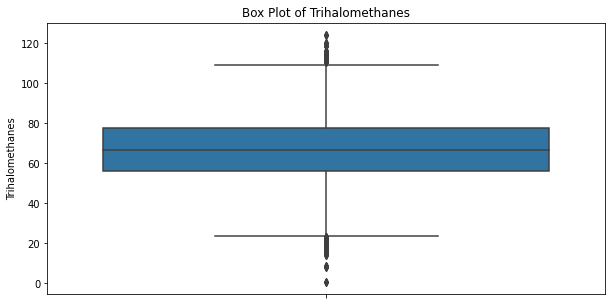

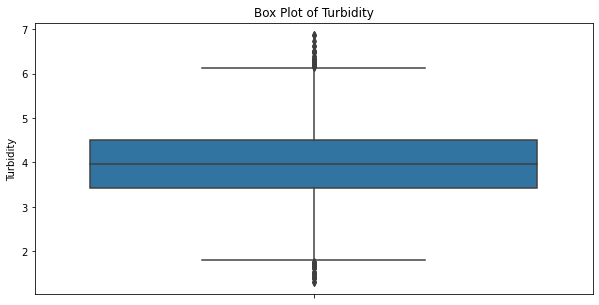

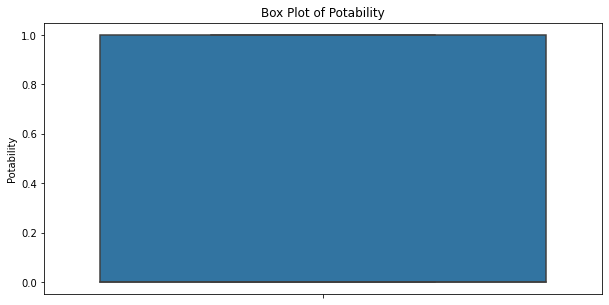

In [8]:
# 画箱型图
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 将Spark DataFrame转换为Pandas DataFrame
pdf = data.toPandas()

# 为每个变量绘制单独的箱型图
for column in pdf.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(y=pdf[column])
    plt.title(f"Box Plot of {column}")
    plt.show()

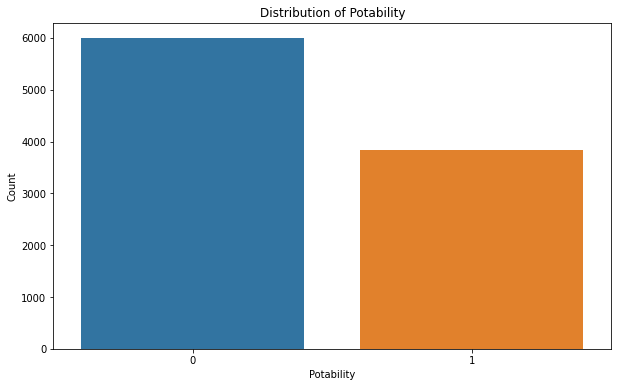

In [9]:
# 绘制potability变量的分布直方图
plt.figure(figsize=(10, 6))
sns.countplot(x=pdf['Potability'])
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Distribution of Potability')
plt.xticks([0, 1])  # 确保x轴上只有0和1
plt.show()

In [10]:
# 删除Hardness列
data = data.drop('Hardness')

# 展示剩余的列
print("Remaining columns after deleting 'Hardness':")
print(data.columns)


Remaining columns after deleting 'Hardness':
['ph', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


In [11]:
data.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



In [14]:
# 处理空值
from pyspark.sql.functions import mean
means = data.select([mean(col).alias(col) for col in data.columns if col != 'Potability']).collect()[0].asDict()

# 用平均值填充空值
data_clean = data.fillna(means)


#缺失值
missing_values = data_clean.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data.columns])

# 将结果转换为 Pandas 进行进一步处理
missing_data = missing_values.toPandas().transpose()
missing_data.columns = ["missing_count"]

print("Columns with missing values:")
print(missing_data)

Columns with missing values:
                 missing_count
ph                           0
Solids                       0
Chloramines                  0
Sulfate                      0
Conductivity                 0
Organic_carbon               0
Trihalomethanes              0
Turbidity                    0
Potability                   0


In [16]:
# 处理离群值
from pyspark.sql.functions import col
# 计算每列的IQR
quantiles = data_clean.approxQuantile([col for col in data.columns if col != 'Potability'], [0.25, 0.75], 0.05)

# 创建一个字典存储每列的上下四分位点和IQR
iqr_dict = {col: (quantiles[i][0], quantiles[i][1], quantiles[i][1] - quantiles[i][0]) 
            for i, col in enumerate(data_clean.columns) if col != 'Potability'}

# 删除离群值和极值
for col_name, (Q1, Q3, IQR) in iqr_dict.items():
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_clean = data_clean.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

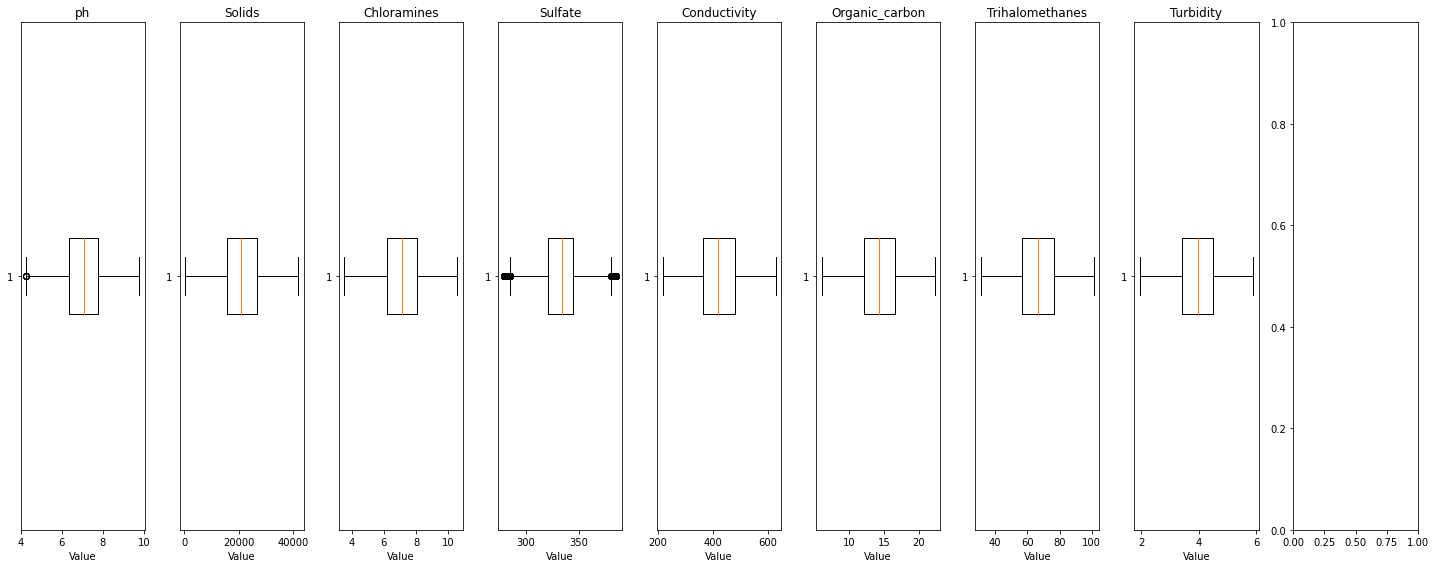

In [17]:
# 画删除了离群值的箱型图
# 将处理后的数据转换为Pandas DataFrame
data_clean_pdf = data_clean.toPandas()

# 绘制箱型图
fig, axes = plt.subplots(nrows=1, ncols=len(data_clean_pdf.columns), figsize=(20, 8))

for i, col in enumerate(data_clean_pdf.columns):
    if col != 'Potability':  # 只绘制特征列的箱型图，不包括目标列
        axes[i].boxplot(data_clean_pdf[col].dropna(), vert=False)
        axes[i].set_title(col)
        axes[i].set_xlabel('Value')

plt.tight_layout()
plt.show()

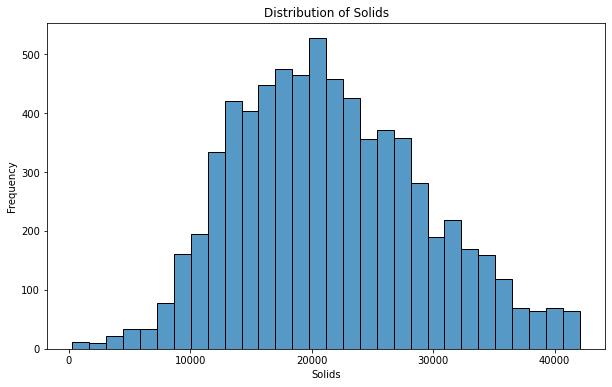

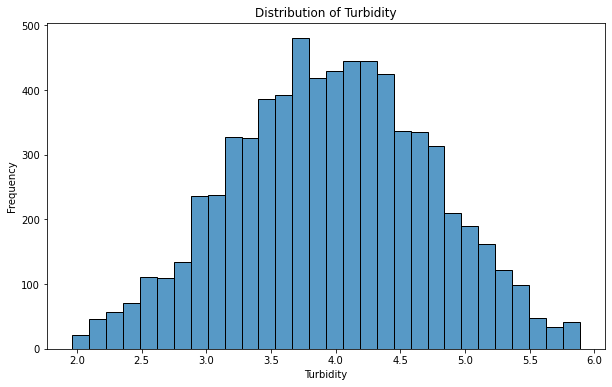

In [18]:
# 将处理后的数据转换为Pandas DataFrame
data_clean_pdf = data_clean.toPandas()

# 绘制 Solids 变量的直方图
plt.figure(figsize=(10, 6))
sns.histplot(data_clean_pdf['Solids'].dropna(), bins=30, kde=False)
plt.title('Distribution of Solids')
plt.xlabel('Solids')
plt.ylabel('Frequency')
plt.show()

# 绘制 Turbidity 变量的直方图
plt.figure(figsize=(10, 6))
sns.histplot(data_clean_pdf['Turbidity'].dropna(), bins=30, kde=False)
plt.title('Distribution of Turbidity')
plt.xlabel('Turbidity')
plt.ylabel('Frequency')
plt.show()

In [19]:
# 创建新列
from pyspark.sql.functions import when
# 定义分类逻辑并创建新列 'Degree of Turbidity'
data_clean = data_clean.withColumn(
    'Degree of Turbidity',
    when(data_clean['Turbidity'] < 3, 'Clear')
    .when((data_clean['Turbidity'] >= 3) & (data_clean['Turbidity'] < 5), 'Slightly Turbidity')
    .otherwise('Turbidity')
)

# 显示前几行数据来确认新列的创建
data_clean.select('Turbidity', 'Degree of Turbidity').show(5)

+------------------+-------------------+
|         Turbidity|Degree of Turbidity|
+------------------+-------------------+
|2.9631353806316407|              Clear|
|3.0559337496641685| Slightly Turbidity|
| 4.628770536837084| Slightly Turbidity|
| 4.075075425430034| Slightly Turbidity|
|2.5597082275565217|              Clear|
+------------------+-------------------+
only showing top 5 rows



In [20]:
# 读取合并三个数据集
# 读取三个CSV文件
df1 = spark.read.csv("water_potability.csv", header=True, inferSchema=True)
df2 = spark.read.csv("water_potability_2.csv", header=True, inferSchema=True)
df3 = spark.read.csv("water_potability_3.csv", header=True, inferSchema=True)

# 合并三个DataFrame
df = df1.union(df2).union(df3)

# 获取新数据的行数和列数
num_rows = df.count()
num_cols = len(df.columns)

# 输出行数和列数
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 9828
Number of columns: 10


In [23]:
data_clean.printSchema()

root
 |-- ph: double (nullable = false)
 |-- Solids: double (nullable = false)
 |-- Chloramines: double (nullable = false)
 |-- Sulfate: double (nullable = false)
 |-- Conductivity: double (nullable = false)
 |-- Organic_carbon: double (nullable = false)
 |-- Trihalomethanes: double (nullable = false)
 |-- Turbidity: double (nullable = false)
 |-- Potability: integer (nullable = true)
 |-- Degree of Turbidity: string (nullable = false)



In [24]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# 准备特征向量
feature_columns = [column for column in data_clean.columns if column not in ['Potability', 'Degree of Turbidity']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# 将特征向量添加到DataFrame
data_with_features = assembler.transform(data_clean)

# 选择特征和目标变量列
final_data = data_with_features.select('features', col('Potability').alias('label'))

# 创建线性回归模型
lr = LinearRegression(featuresCol='features', labelCol='label')

# 训练模型
lr_model = lr.fit(final_data)

# 打印系数和截距
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# 打印每个特征的 p 值
for feature, p_value in zip(feature_columns, lr_model.summary.pValues):
    print(f"Feature: {feature}, p-value: {p_value}")

# 打印模型摘要信息
print(f"RMSE: {lr_model.summary.rootMeanSquaredError}")
print(f"r2: {lr_model.summary.r2}")

24/05/23 10:31:06 WARN Instrumentation: [6b2cc5cb] regParam is zero, which might cause numerical instability and overfitting.
24/05/23 10:31:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 10:31:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/23 10:31:06 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [0.0034329226574144945,1.1121890165127248e-06,0.0027618990238321203,-0.0003979752328580373,-5.3028082786478635e-05,-0.0020356422746574706,0.0003173992423620779,0.0007902278712276424]
Intercept: 0.46516835586235444
Feature: ph, p-value: 0.5025271564571927
Feature: Solids, p-value: 0.13884239769599738
Feature: Chloramines, p-value: 0.5152765476875172
Feature: Sulfate, p-value: 0.12319188853284735
Feature: Conductivity, p-value: 0.47266950344774505
Feature: Organic_carbon, p-value: 0.27610862215373233
Feature: Trihalomethanes, p-value: 0.4321780669012787
Feature: Turbidity, p-value: 0.9171093946206552
RMSE: 0.4833175864588196
r2: 0.0011134188780109744


In [30]:
training = data_clean.sample(withReplacement=False, fraction=0.85, seed=888)

# 显示行数
print(f"Number of rows in the training data: {training.count()}")

Number of rows in the training data: 5955


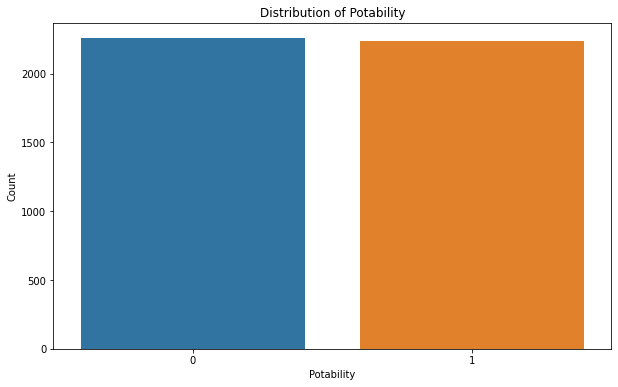

In [32]:
# 欠采样
# 分割多数类和少数类样本
train_major = training.filter(col('Potability') == 0)
train_minor = training.filter(col('Potability') == 1)

# 计算多数类样本和少数类样本的数量
n_major = train_major.count()
n_minor = train_minor.count()

# 从多数类中随机选择和少数类相同数量的样本
train_major_sampled = train_major.sample(withReplacement=False, fraction=n_minor / n_major, seed=42)

# 合并多数类下采样后的样本与少数类样本
train_down = train_major_sampled.union(train_minor)

# 洗牌数据
train_down = train_down.orderBy(F.rand(seed=42))

# 绘制potability变量的分布直方图
pdf = train_down.toPandas()
plt.figure(figsize=(10, 6))
sns.countplot(x=pdf['Potability'])
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Distribution of Potability')
plt.xticks([0, 1])  # 确保x轴上只有0和1
plt.show()


In [33]:
final_output_path = "final_data.csv"
train_down.write.csv(final_output_path, header=True, mode='overwrite')